# Appendix: helper functions

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display

Here we create some helper functions that will be used across notebooks using the magic `%%writefile`.

## Data visualisation

Data exploration, in particular based on visualisation, is crucial to modern data science. `Pandas` has a lot of plotting functionalities (e.g. see the graph below), but we will find it usefull to use a custom `plot` set of functions.

In [2]:
%%writefile ../skfin/plot.py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skfin.metrics import sharpe_ratio

plt.style.use("seaborn-whitegrid")


def set_axis(ax=None, figsize=(8, 5), title=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if title is not None:
        ax.set_title(title)
    return fig, ax


def line(
    df,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title="",
    cumsum=False,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    legend_sharpe_ratio=None,
    legend=True,
    yscale=None,
    start_date=None,
):
    df = df.copy()
    if loc == "best":
        bbox_to_anchor = None
    if isinstance(df, dict) | isinstance(df, list):
        df = pd.concat(df, axis=1)
    if isinstance(df, pd.Series):
        df = df.to_frame()
    if start_date is not None:
        df = df[start_date:]
    if cumsum & (legend_sharpe_ratio is None):
        legend_sharpe_ratio = True
    if legend_sharpe_ratio:
        df.columns = [f"{c}: sr={sharpe_ratio(df[c]): 3.2f}" for c in df.columns]
    if cumsum:
        df = df.cumsum()
    if sort:
        df = df.loc[:, lambda x: x.iloc[-1].sort_values(ascending=False).index]
    if ax is None:
        fig, ax = set_axis(ax=ax, figsize=figsize)
    if title != '': 
        ax.set_title(title)
    ax.plot(df.index, df.values)
    if legend:
        ax.legend(df.columns, loc=loc, bbox_to_anchor=bbox_to_anchor)
    if yscale == "log":
        ax.set_yscale("log")


def bar(
    df,
    err=None,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title=None,
    horizontal=False,
    baseline=None,
    rotation=0,
):
    if isinstance(df, pd.DataFrame):
        df = df.squeeze()
    if isinstance(df, dict):
        df = pd.Series(df)
    if sort:
        df = df.sort_values()
    if err is not None:
        err = err.loc[df.index]
    labels = df.index
    x = np.arange(len(labels))
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title)
    if horizontal:
        ax.barh(x, df.values, xerr=err, capsize=5)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.barh(x, df_.values, color="lightgreen")
    else:
        ax.bar(x, df.values, yerr=err, capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.bar(x, df_.values, color="lightgreen")
    ax.set_title(title)


def heatmap(
    df,
    ax=None,
    fig=None, 
    figsize=(8, 5),
    title=None,
    vmin=None,
    vmax=None,
    vcompute=True,
    cmap="RdBu",
):
    labels_x = df.index
    x = np.arange(len(labels_x))
    labels_y = df.columns
    y = np.arange(len(labels_y))
    if vcompute:
        vmax = df.abs().max().max()
        vmin = -vmax
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title, fig=fig)
    pos = ax.imshow(
        df.T.values, cmap=cmap, interpolation="nearest", vmax=vmax, vmin=vmin
    )
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(labels_x, rotation=90)
    ax.set_yticklabels(labels_y)
    ax.grid(True)
    fig.colorbar(pos, ax=ax)


def scatter(
    df,
    ax=None,
    xscale=None,
    yscale=None,
    xlabel=None,
    ylabel=None,
    xticks=None,
    yticks=None,
    figsize=(8, 5),
    title=None,
):
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title)
    ax.scatter(df, df.index, facecolors="none", edgecolors="b", s=50)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xscale is not None:
        ax.set_xscale(xscale)
    if yscale is not None:
        ax.set_yscale(yscale)
    if yticks is not None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)

Overwriting ../skfin/plot.py


In [3]:
from skfin.plot import bar, heatmap, line

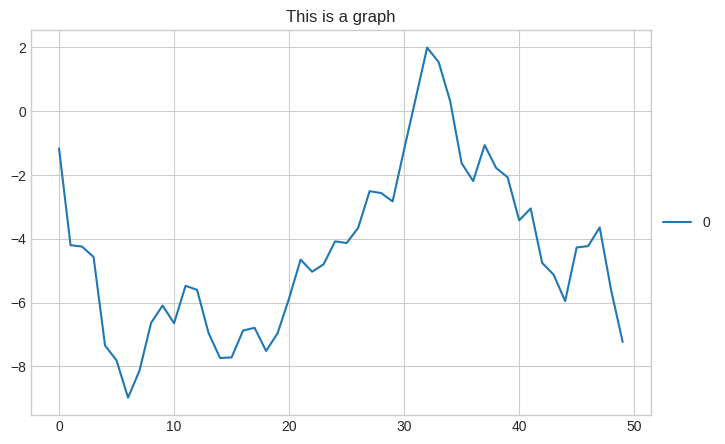

In [4]:
line(
    pd.Series(np.random.normal(size=50)),
    cumsum=True,
    title="This is a graph",
    legend_sharpe_ratio=False,
)

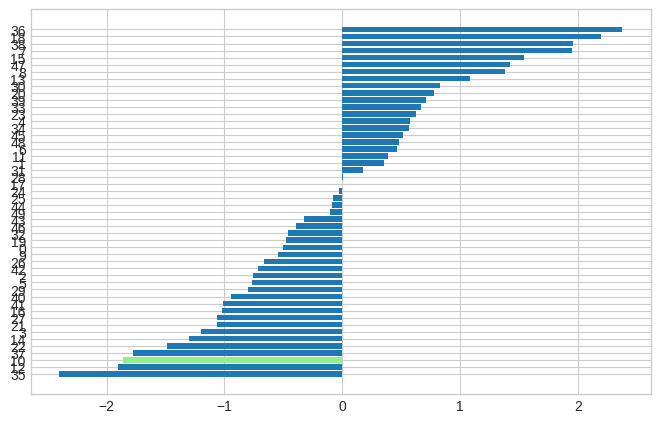

In [5]:
bar(pd.Series(np.random.normal(size=50)), baseline=10, horizontal=True)

## Dates and mappings

In [6]:
%%writefile ../skfin/dataloaders/constants/mappings.py
"""
Mapping dictionaries for various datasets and symbols.
"""

symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}

mapping_10X = {
    "AAPL": ["APPLE COMPUTER INC", "APPLE INC"],
    "AIG": "AMERICAN INTERNATIONAL GROUP INC",
    "AMZN": "AMAZON COM INC",
    "AXP": "AMERICAN EXPRESS CO",
    "BA": "BOEING CO",
    "BAC": "BANK OF AMERICA CORP /DE/",
    "CAT": "CATERPILLAR INC",
    "CL": "COLGATE PALMOLIVE CO",
    "CMCSA": "COMCAST CORP",
    "COP": "CONOCOPHILLIPS",
    "CSCO": "CISCO SYSTEMS INC",
    "CVC": "CABLEVISION SYSTEMS CORP /NY",
    "CVS": ["CVS CORP", "CVS/CAREMARK CORP", "CVS CAREMARK CORP"],
    "CVX": ["CHEVRONTEXACO CORP", "CHEVRON CORP"],
    "DD": "DUPONT E I DE NEMOURS & CO",
    "DELL": ["DELL COMPUTER CORP", "DELL INC"],
    "F": "FORD MOTOR CO",
    "GD": "GENERAL DYNAMICS CORP",
    "GE": "GENERAL ELECTRIC CO",
    "GS": "GOLDMAN SACHS GROUP INC/",
    "HD": "HOME DEPOT INC",
    "HPQ": "HEWLETT PACKARD CO",
    "IBM": "INTERNATIONAL BUSINESS MACHINES CORP",
    "JPM": "J P MORGAN CHASE & CO",
    "K": "KELLOGG CO",
    "KMB": "KIMBERLY CLARK CORP",
    "KO": "COCA COLA CO",
    "MAR": "MARRIOTT INTERNATIONAL INC /MD/",
    "MCD": "MCDONALDS CORP",
    "MMM": "3M CO",
    "MSFT": "MICROSOFT CORP",
    "NAV": "NAVISTAR INTERNATIONAL CORP",
    "NOC": "NORTHROP GRUMMAN CORP /DE/",
    "PEP": "PEPSI BOTTLING GROUP INC",
    "PFE": "PFIZER INC",
    "PG": "PROCTER & GAMBLE CO",
    "R": "RYDER SYSTEM INC",
    "RTN": "RAYTHEON CO/",
    "TWX": ["AOL TIME WARNER INC", "TIME WARNER INC"],
    "TXN": "TEXAS INSTRUMENTS INC",
    "VLO": "VALERO ENERGY CORP/TX",
    "WFC": "WELLS FARGO & CO/MN",
    "WMT": "WAL MART STORES INC",
    "XOM": "EXXON MOBIL CORP",
    "XRX": "XEROX CORP",
    "YHOO": "YAHOO INC",
}

Overwriting ../skfin/dataloaders/constants/mappings.py


In [7]:
%%writefile ../skfin/dataloaders/constants/dates.py
import pandas as pd


def load_fomc_change_date(as_datetime=True):
    """
    Return the dates of FOMC interest rate changes.

    Args:
        as_datetime: If True, convert dates to datetime format

    Returns:
        Tuple of two lists: (increase dates, decrease dates)
    """
    change_up = [
        "1999-06-30",
        "1999-08-24",
        "1999-11-16",
        "2000-02-02",
        "2000-03-21",
        "2000-05-16",
        "2004-06-30",
        "2004-08-10",
        "2004-09-21",
        "2004-11-10",
        "2004-12-14",
        "2005-02-02",
        "2005-03-22",
        "2005-05-03",
        "2005-06-30",
        "2005-08-09",
        "2005-09-20",
        "2005-11-01",
        "2005-12-13",
        "2006-01-31",
        "2006-03-28",
        "2006-05-10",
        "2006-06-29",
        "2015-12-16",
        "2016-12-14",
        "2017-03-15",
        "2017-06-14",
        "2017-12-13",
        "2018-03-21",
        "2018-06-13",
        "2018-09-26",
        "2018-12-19",
        "2022-03-16",
        "2022-05-04",
        "2022-06-15",
        "2022-07-27",
    ]

    change_dw = [
        "2001-01-03",
        "2001-01-31",
        "2001-03-20",
        "2001-04-18",
        "2001-05-15",
        "2001-06-27",
        "2001-08-21",
        "2001-09-17",
        "2001-10-02",
        "2001-11-06",
        "2001-12-11",
        "2002-11-06",
        "2003-06-25",
        "2007-09-18",
        "2007-10-31",
        "2007-12-11",
        "2008-01-22",
        "2008-01-30",
        "2008-03-18",
        "2008-04-30",
        "2008-10-08",
        "2008-10-29",
        "2008-12-16",
        "2019-07-31",
        "2019-09-18",
        "2019-10-30",
        "2020-03-03",
        "2020-03-15",
    ]
    if as_datetime:
        change_up, change_dw = pd.to_datetime(change_up), pd.to_datetime(change_dw)

    return change_up, change_dw


def load_us_politics_dates():
    us_politics = {
        "03-1925": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "Republican",
        },
        "03-1933": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1947": {
            "Presidency": "Democratic",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-1949": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1953": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-1955": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1961": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1969": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1981": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Republican",
        },
        "01-1987": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1993": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-1995": {
            "Presidency": "Democratic",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-2001": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "50-50 Split",
        },
        "06-2001": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "Democratic",
        },
        "01-2003": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-2007": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-2009": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
        "01-2011": {
            "Presidency": "Democratic",
            "House": "Republican",
            "Senate": "Democratic",
        },
        "01-2015": {
            "Presidency": "Democratic",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-2017": {
            "Presidency": "Republican",
            "House": "Republican",
            "Senate": "Republican",
        },
        "01-2019": {
            "Presidency": "Republican",
            "House": "Democratic",
            "Senate": "Republican",
        },
        "01-2021": {
            "Presidency": "Democratic",
            "House": "Democratic",
            "Senate": "Democratic",
        },
    }
    return pd.DataFrame.from_dict(us_politics, orient="index").pipe(
        lambda d: d.set_index(pd.to_datetime(d.index, format="%m-%Y"))
    )

Overwriting ../skfin/dataloaders/constants/dates.py


## Data utils

In [8]:
%%writefile ../skfin/dataloaders/cache.py
import logging
import sys
from pathlib import Path
from typing import Any, Union, Callable

import pandas as pd

from skfin.dataloaders.io_utils import clean_directory_path, load_dict, save_dict


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)


class CacheManager:
    """Manages loading and saving data to cache."""

    def __init__(self, cache_dir: str = "data"):
        self.cache_dir = clean_directory_path(cache_dir)
        self.logger = logging.getLogger(__name__)

    def get_cached_dataframe(
        self,
        filename: Union[str, Path],
        loader_func: Callable,
        force_reload: bool = False,
        **kwargs,
    ) -> Any:
        """
        Load a DataFrame from cache or get it via a loader function.

        Args:
            filename: Cache filename
            loader_func: Function to call to load data if not present in cache
            force_reload: If True, ignore cache and reload data
            **kwargs: Additional arguments to pass to loader_func

        Returns:
            Loaded DataFrame or other object
        """

        if isinstance(filename, str):
            filename = Path(filename)

        full_path = self.cache_dir / filename

        if (full_path.exists()) & (not force_reload):
            self.logger.info(f"Loading from cache : {full_path}")
            if filename.suffix == ".parquet":
                return pd.read_parquet(full_path)
            elif filename.suffix == ".csv":
                return pd.read_csv(full_path)
            elif filename.suffix == ".xlsx":
                if "sheet_name" in kwargs:
                    return pd.read_excel(full_path, sheet_name=kwargs["sheet_name"])
                else:
                    return pd.read_excel(full_path)
            else:
                return load_dict(full_path)
        else:
            self.logger.info("Loading from an external source")
            data = loader_func(**kwargs)
            self.save_to_cache(data, full_path)
            return data

    def save_to_cache(self, data: Any, path: Path) -> None:
        """Saving to cache."""
        self.logger.info(f"Sauvegarde dans le cache : {path}")
        if isinstance(data, pd.DataFrame):
            if path.suffix == ".parquet":
                data.to_parquet(path)
            elif path.suffix == ".csv":
                data.to_csv(path)
        else:
            save_dict(data, path)


Overwriting ../skfin/dataloaders/cache.py


In [9]:
%%writefile ../skfin/dataloaders/cleaners.py
from typing import Dict, List, Optional

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup


class DataCleaner:
    """Utilities for data cleaning."""

    @staticmethod
    def clean_kf_dataframes(df: pd.DataFrame, multi_df: bool = False) -> Dict:
        """Extract annual and monthly dataframes from the CSV file with specific formatting."""
        idx = [-2] + list(np.where(df.notna().sum(axis=1) == 0)[0])
        if multi_df:
            cols = ["  Average Value Weighted Returns -- Monthly"] + list(
                df.loc[df.notna().sum(axis=1) == 0].index
            )
        returns_data = {"Annual": {}, "Monthly": {}}
        for i in range(len(idx)):
            if multi_df:
                c_ = (
                    cols[i]
                    .replace("-- Annual", "")
                    .replace("-- Monthly", "")
                    .strip()
                    .replace("/", " ")
                    .replace(" ", "_")
                )
            if i != len(idx) - 1:
                v = df.iloc[idx[i] + 2 : idx[i + 1] - 1].astype(float)
                v.index = v.index.str.strip()
                if len(v) != 0:
                    if len(v.index[0]) == 6:
                        v.index = pd.to_datetime(v.index, format="%Y%m")
                        if multi_df:
                            returns_data["Monthly"][c_] = v
                        else:
                            returns_data["Monthly"] = v
                        continue
                    if len(v.index[0]) == 4:
                        v.index = pd.to_datetime(v.index, format="%Y")
                        if multi_df:
                            returns_data["Annual"][c_] = v
                        else:
                            returns_data["Annual"] = v
        return returns_data

    @staticmethod
    def sent_cleaner(s: str) -> str:
        """Clean a text string by removing line breaks and excess spaces."""
        return s.replace("\n", " ").replace("\r", " ").replace("\t", " ").strip()

    @staticmethod
    def bs_cleaner(
        bs: BeautifulSoup, html_tag_blocked: Optional[List[str]] = None
    ) -> List[str]:
        """Extract text from a BeautifulSoup object excluding certain HTML tags."""
        if html_tag_blocked is None:
            html_tag_blocked = [
                "style",
                "script",
                "[document]",
                "meta",
                "a",
                "span",
                "label",
                "strong",
                "button",
                "li",
                "h6",
                "font",
                "h1",
                "h2",
                "h3",
                "h5",
                "h4",
                "em",
                "body",
                "head",
                "sup",
            ]
        return [
            DataCleaner.sent_cleaner(t)
            for t in bs.find_all(text=True)
            if (t.parent.name not in html_tag_blocked)
            & (len(DataCleaner.sent_cleaner(t)) > 0)
        ]


Overwriting ../skfin/dataloaders/cleaners.py


In [10]:
%%writefile ../skfin/dataloaders/fomc.py
import re
from typing import List, Optional

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup


class FomcUtils:
    """Utilities for processing FOMC data."""

    regexp = re.compile(r"\s+", re.UNICODE)

    @staticmethod
    def get_fomc_urls(
        from_year: int = 1999, switch_year: Optional[int] = None
    ) -> List[str]:
        """Get URLs of FOMC statements from a specific year."""
        if switch_year is None:
            from datetime import datetime

            switch_year = datetime.now().year - 5

        calendar_url = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
        r = requests.get(calendar_url)
        soup = BeautifulSoup(r.text, "html.parser")
        contents = soup.find_all(
            "a", href=re.compile("^/newsevents/pressreleases/monetary\d{8}[ax].htm")
        )
        urls_ = [content.attrs["href"] for content in contents]

        for year in range(from_year, switch_year):
            yearly_contents = []
            fomc_yearly_url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm"
            r_year = requests.get(fomc_yearly_url)
            soup_yearly = BeautifulSoup(r_year.text, "html.parser")
            yearly_contents = soup_yearly.findAll("a", text="Statement")
            for yearly_content in yearly_contents:
                urls_.append(yearly_content.attrs["href"])

        urls = ["https://www.federalreserve.gov" + url for url in urls_]
        return urls

    @staticmethod
    def feature_extraction(
        corpus: List, sent_filters: Optional[List[str]] = None
    ) -> pd.DataFrame:
        """Extract features from FOMC statements."""
        if sent_filters is None:
            sent_filters = [
                "Board of Governors",
                "Federal Reserve System",
                "20th Street and Constitution Avenue N.W., Washington, DC 20551",
                "Federal Reserve Board - Federal Reserve issues FOMC statement",
                "For immediate release",
                "Federal Reserve Board - FOMC statement",
                "DO NOT REMOVE:  Wireless Generation",
                "For media inquiries",
                "or call 202-452-2955.",
                "Voting",
                "For release at",
                "For immediate release",
                "Last Update",
                "Last update",
            ]

        corpus = [c if "Release Date: " in c[1] else c[9:] for c in corpus]

        text = [
            " ".join(
                [
                    FomcUtils.regexp.sub(" ", s)
                    for i, s in enumerate(c)
                    if (i > 1) & np.all([q not in s for q in sent_filters])
                ]
            )
            for c in corpus
        ]

        release_date = [
            pd.to_datetime(c[1].replace("Release Date: ", "")) for c in corpus
        ]
        last_update = [
            pd.to_datetime(
                [
                    s.replace("Last update:", "").replace("Last Update:", "").strip()
                    for s in c
                    if "last update: " in s.lower()
                ][0]
            )
            for c in corpus
        ]
        voting = [" ".join([s for s in c if "Voting" in s]) for c in corpus]
        release_time = [
            " ".join(
                [
                    s
                    for s in c
                    if ("For release at" in s) | ("For immediate release" in s)
                ]
            )
            for c in corpus
        ]

        return pd.DataFrame(
            {
                "release_date": release_date,
                "last_update": last_update,
                "text": text,
                "voting": voting,
                "release_time": release_time,
            }
        )


Overwriting ../skfin/dataloaders/fomc.py


In [11]:
%%writefile ../skfin/dataloaders/io_utils.py
import os
from pathlib import Path
from typing import Dict, Union, Any

import pandas as pd


def clean_directory_path(
    cache_dir: Union[str, Path, None], default_dir: str = "data"
) -> Path:
    """
    Ensure a directory path exists, creating it if necessary.

    Args:
        cache_dir: Directory path to clean/create
        default_dir: Default directory name if cache_dir is None

    Returns:
        Path object to the clean directory
    """
    if cache_dir is None:
        cache_dir = Path(os.getcwd()) / default_dir
    if isinstance(cache_dir, str):
        cache_dir = Path(cache_dir)
    if not cache_dir.is_dir():
        os.makedirs(cache_dir)
    return cache_dir


def save_dict(data: Dict[str, Any], output_dir: Path) -> None:
    """
    Recursively save a dictionary structure to disk.

    Args:
        data: Dictionary to save
        output_dir: Directory path where to save data
    """
    assert isinstance(data, dict)
    if not output_dir.is_dir():
        os.makedirs(output_dir)
    for k, v in data.items():
        if isinstance(v, pd.DataFrame):
            v.to_parquet(output_dir / f"{k}.parquet")
        else:
            save_dict(v, output_dir=output_dir / k)


def load_dict(input_dir: Path) -> Dict[str, Any]:
    """
    Recursively load a dictionary structure from disk.

    Args:
        input_dir: Directory path from which to load data

    Returns:
        Dictionary with loaded data
    """
    data = {}
    for o in os.scandir(input_dir):
        if o.name.endswith(".parquet"):
            k = o.name.replace(".parquet", "")
            data[k] = pd.read_parquet(o)
        elif o.is_dir():
            data[o.name] = load_dict(o)
    return data


Overwriting ../skfin/dataloaders/io_utils.py


In [12]:
%%writefile ../skfin/dataloaders/web_utils.py
from io import BytesIO
from zipfile import ZipFile

import requests
from bs4 import BeautifulSoup


class WebUtils:
    """Utilities for web requests and parsing."""

    @staticmethod
    def get_response(url: str) -> requests.Response:
        """Perform a GET request and return the response."""
        return requests.get(url)

    @staticmethod
    def download_zip_content(url: str) -> ZipFile:
        """Download and return the content of a ZIP file from a URL."""
        r = WebUtils.get_response(url)
        return ZipFile(BytesIO(r.content))

    @staticmethod
    def parse_html(content: str) -> BeautifulSoup:
        """Parse HTML content with BeautifulSoup."""
        return BeautifulSoup(content, "html.parser")


Overwriting ../skfin/dataloaders/web_utils.py
